In [6]:
# install dependencies
%pip install numpy
%pip install matplotlib
%pip install torch torchvision
%pip install opencv-python
%pip install Pillow
%pip install imutils
%pip install super_gradients
%pip install albumentations 
%pip install split-folders

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached opencv_python-4.8.1.78-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
Using cached opencv_python-4.8.1.78-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (61.7 MB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached imutils-0.5.4-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.
  Using cached super_gradients-3.5.0-py3-none-any.whl.metadata (39 kB)
  Using cached tqdm-4.66.1-py3-none-any.whl.metadata (57 kB)
  Using cached boto3-1.34.7-py3-none-any.whl.metadata (6.6 kB)
  Using cached Deprecated-1.2.14-py2.py3-none-any.whl.metadata (5.4 kB)
  Using cached tensorboard-2.14.0-py3-none-any.whl.metadata (1.8 kB)
  Using

In [7]:
import math
import random
from typing import List,Tuple
import requests

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path, PurePath
import pathlib

import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms

from PIL import Image

import albumentations as A

from imutils import paths

import textwrap

from super_gradients.training import Trainer
from super_gradients.training import training_hyperparams
from super_gradients.training.metrics.classification_metrics import Accuracy, Top5
from super_gradients.training.utils.early_stopping import EarlyStop
from super_gradients.training import models
from super_gradients.training.utils.callbacks import Phase

[2023-12-24 14:36:45] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2023-12-24 14:36:45] WARNING - __init__.py - Failed to import pytorch_quantization


The console stream is logged into /home/pc_home/sg_logs/console.log


[2023-12-24 14:36:45] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-12-24 14:36:45] WARNING - export.py - Failed to import pytorch_quantization
[2023-12-24 14:36:45] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


# Number of classes

Simple utility to fetch the number of classes.

In [8]:
def count_subdirectories(path: str) -> int:
    """
    Counts the number of subdirectories in the given directory path.
    """
    dir_path = Path(path)
    subdirectories = [f for f in dir_path.iterdir() if f.is_dir()]
    return len(subdirectories)

# Example usage
parent_dir = "./data/train"
num_species = count_subdirectories(parent_dir)
print(f"Number of subdirectories in {parent_dir}: {num_species}")

# Config 

This holds variables for the notebook.

Define the model, training params, image type, number of classes, and  relevant directories in this class.

In [9]:
class config:
    # specify the paths to datasets
    ROOT_DIR = Path('./data/')
    TRAIN_DIR = ROOT_DIR.joinpath('train')
    TEST_DIR = ROOT_DIR.joinpath('test')
    VAL_DIR = ROOT_DIR.joinpath('valid')

    # set the input height and width
    INPUT_HEIGHT = 224
    INPUT_WIDTH = 224

    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]
    
    IMAGE_TYPE = '.jpg'
    BATCH_SIZE = 128
    MODEL_NAME = 'resnet50'
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    TRAINING_PARAMS = 'training_hyperparams/imagenet_resnet50_train_params'
    
    NUM_CLASSES = num_species
    
    CHECKPOINT_DIR = ROOT_DIR.joinpath('checkpoints')


# Plot random images

Number of subdirectories in ./data/train: 525


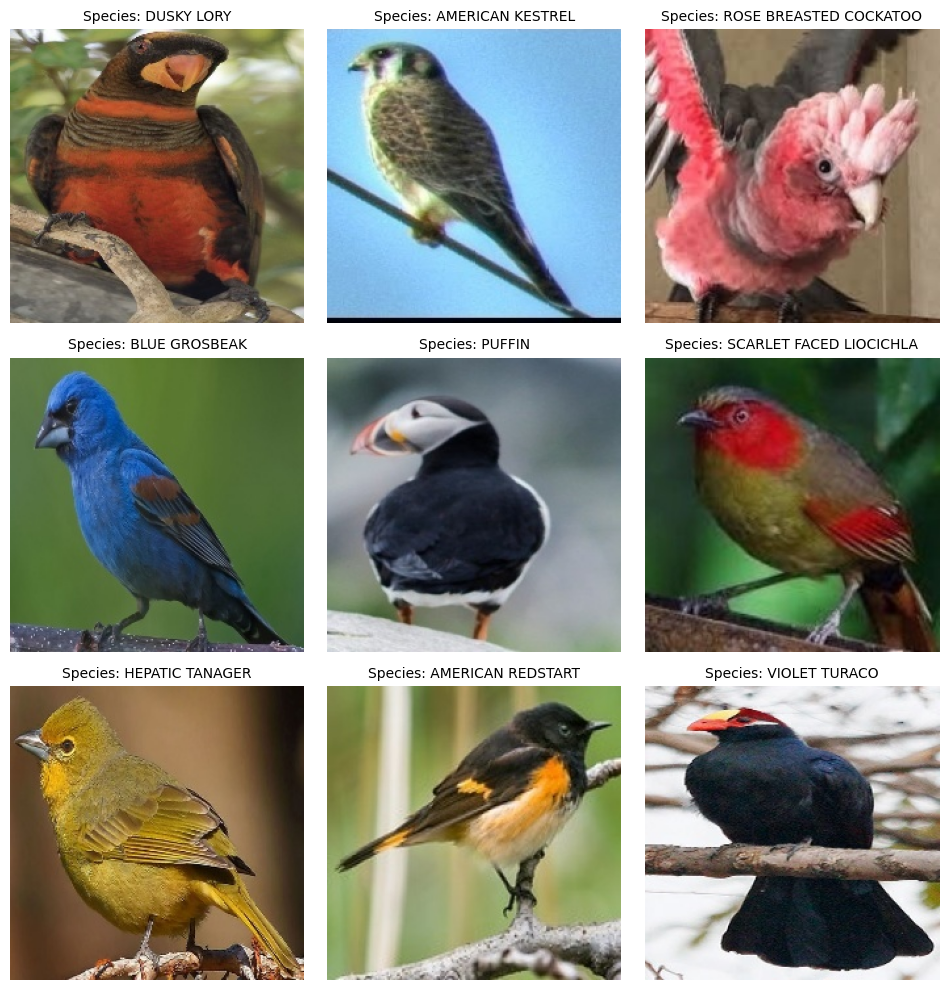

In [10]:
train_image_path_list = list(sorted(paths.list_images(config.TRAIN_DIR)))
train_image_path_sample = random.sample(population=train_image_path_list, k=9)

def examine_images(images:list):
    num_images = len(images)
    num_rows = int(math.ceil(num_images/3))
    num_cols = 3
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10),tight_layout=True)
    axs = axs.ravel()

    for i, image_path in enumerate(images[:num_images]):
        image = Image.open(image_path)
        label = PurePath(image_path).parent.name
        axs[i].imshow(image)
        axs[i].set_title(f"Species: {label}", fontsize=10)
        axs[i].axis('off')
    
    # save the sample images
    plt.savefig('./figures/sample_images.png', format='png', dpi=600)

examine_images(train_image_path_sample)

# Augmentations


In [11]:
# initialize our data augmentation functions
resize = transforms.Resize(size=(config.INPUT_HEIGHT,config.INPUT_WIDTH))
make_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=config.IMAGENET_MEAN, std=config.IMAGENET_STD)
center_cropper = transforms.CenterCrop((config.INPUT_HEIGHT,config.INPUT_WIDTH))
random_horizontal_flip = transforms.RandomHorizontalFlip(p=0.5)
random_vertical_flip = transforms.RandomVerticalFlip(p=0.5)
random_rotation = transforms.RandomRotation(degrees=180)
random_crop = transforms.RandomCrop(size=(170,170))
random_erasing = transforms.RandomErasing()
augmix = transforms.AugMix(severity = 4, mixture_width=4, alpha=0.65)

# initialize our training and validation set data augmentation pipeline
train_transforms = transforms.Compose([
  resize, 
  augmix,
  center_cropper,
  random_crop,
  random_horizontal_flip,
  random_vertical_flip,
  random_rotation,
  make_tensor,
  normalize
])

val_transforms = transforms.Compose([resize, make_tensor, normalize])

# Show what one image looks like after augmentation

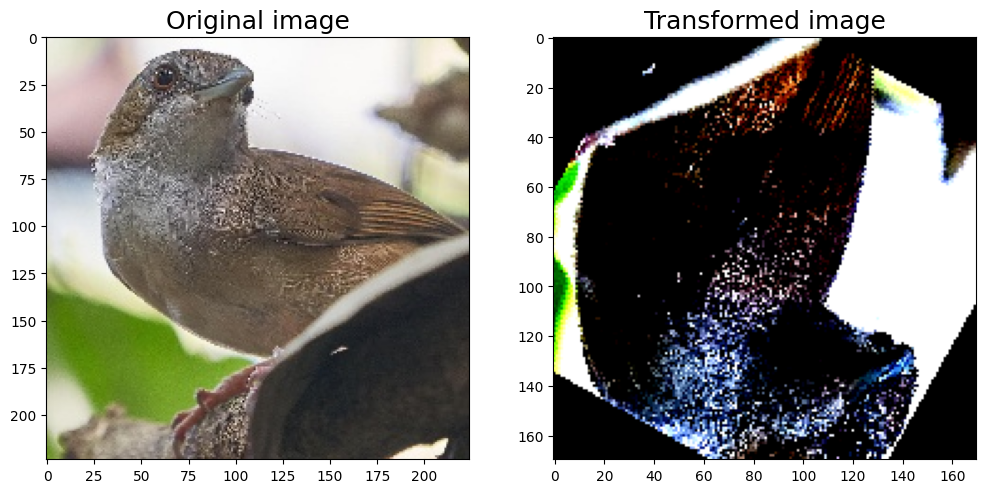

In [12]:
def apply_transform(img: Image, transform) -> np.ndarray:
    """
    Applies a transform to a PIL Image and returns a numpy array of the transformed image.

    Args:
        img (PIL.Image): The input image to transform.
        transform (torchvision.transforms.Compose): The transform to apply to the image.

    Returns:
        np.ndarray: A numpy array representing the transformed image.
    """
    # Apply the transform to the image
    if isinstance(transform, torchvision.transforms.Compose):
        # Apply PyTorch transform to image array
        transformed_image = train_transforms(img)

    elif isinstance(transform, A.Compose):
        # Apply Albumentations transform to image array
        img_array = np.array(img)
        transformed_image = transform(image=img_array)["image"]

    # Convert the image tensor to a numpy array and transpose the axes to (height, width, channels)
    img_array = transformed_image.numpy().transpose((1, 2, 0))

    # Clip the pixel values to the range [0, 1]
    img_array = np.clip(img_array, 0, 1)

    return img_array


def visualize_transform(image: np.ndarray, original_image: np.ndarray = None) -> None:
    """
    Visualize the transformed image.

    Args:
        image (np.ndarray): A NumPy array representing the transformed image.
        original_image (np.ndarray, optional): A NumPy array representing the original image. Defaults to None.
    """
    fontsize = 18
    
    if original_image is None:
        # Create a plot with 1 row and 2 columns.
        f, ax = plt.subplots(1, 2, figsize=(12, 12))

        # Show the transformed image in the first column.
        ax[0].imshow(image)
    else:
        # Create a plot with 1 row and 2 columns.
        f, ax = plt.subplots(1, 2, figsize=(12, 12))

        # Show the original image in the first column.
        ax[0].imshow(original_image)
        ax[0].set_title('Original image', fontsize=fontsize)
        
        # Show the transformed image in the second column.
        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)
        
img = Image.open(train_image_path_list[0])
img_array = apply_transform(img, train_transforms)

visualize_transform(img_array, original_image=img)

# Datasets and Dataloadrer

In [13]:
def create_dataloaders(
    train_dir: str, 
    val_dir: str,
    test_dir: str,
    train_transform: transforms.Compose,
    val_transform:  transforms.Compose,
    test_transform:  transforms.Compose,
    batch_size: int, 
    num_workers: int=2
):
  """Creates training and validation DataLoaders.
  Args:
    train_dir: Path to training data.
    val_dir: Path to validation data.
    transform: Transformation pipeline.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.
  Returns:
    A tuple of (train_dataloader, val_dataloader, class_names).
  """
  # Use ImageFolder to create dataset
  train_data = datasets.ImageFolder(train_dir, transform=train_transform)
  val_data = datasets.ImageFolder(val_dir, transform=val_transform)
  test_data = datasets.ImageFolder(test_dir, transform=val_transform)  

  print(f"[INFO] training dataset contains {len(train_data)} samples...")
  print(f"[INFO] validation dataset contains {len(val_data)} samples...")
  print(f"[INFO] test dataset contains {len(test_data)} samples...")

  # Get class names
  class_names = train_data.classes
  print(f"[INFO] dataset contains {len(class_names)} labels...")

  # Turn images into data loaders
  print("[INFO] creating training and validation set dataloaders...")
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      drop_last=True,
      num_workers=num_workers,
      pin_memory=True,
      persistent_workers=True
  )
  val_dataloader = DataLoader(
      val_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
      drop_last=False,
      persistent_workers=True
  )

  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
      drop_last=False,
      persistent_workers=True
  )

  return train_dataloader, val_dataloader, test_dataloader, class_names

In [14]:
train_dataloader, valid_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=config.TRAIN_DIR,
                                                                     val_dir=config.VAL_DIR,
                                                                     test_dir=config.TEST_DIR,
                                                                     train_transform=train_transforms,
                                                                     val_transform=val_transforms,
                                                                     test_transform=val_transforms,
                                                                     batch_size=config.BATCH_SIZE)

NUM_CLASSES = len(class_names)

# Training Params

In [15]:
training_params =  training_hyperparams.get(config.TRAINING_PARAMS)

In [16]:
early_stop_acc = EarlyStop(Phase.VALIDATION_EPOCH_END, monitor="Accuracy", mode="max", patience=7, verbose=False)
early_stop_val_loss = EarlyStop(Phase.VALIDATION_EPOCH_END, monitor="LabelSmoothingCrossEntropyLoss", mode="min", patience=7, verbose=False)

training_params["train_metrics_list"] = [Accuracy(), Top5()]
training_params["valid_metrics_list"] = [Accuracy(), Top5()]
training_params["phase_callbacks"] = [early_stop_acc, early_stop_val_loss]

# Set the silent mode to True to reduce clutter in the notebook, you can turn it on to see the full output
training_params["silent_mode"] = True

# Turn off the use of exponential moving average and zero weight decay on bias and batch norm
# training_params['ema'] = False
training_params['zero_weight_decay_on_bias_and_bn'] = False
training_params["optimizer"] = 'Adam'

training_params["criterion_params"] = {'smooth_eps': 0.20}
training_params["max_epochs"] = 250
training_params["initial_lr"] = 0.0001

In [17]:
training_params

{'resume': False,
 'run_id': None,
 'resume_path': None,
 'resume_from_remote_sg_logger': False,
 'ckpt_name': 'ckpt_latest.pth',
 'lr_mode': 'CosineLRScheduler',
 'lr_schedule_function': None,
 'lr_warmup_epochs': 5,
 'lr_warmup_steps': 0,
 'lr_cooldown_epochs': 0,
 'warmup_initial_lr': None,
 'step_lr_update_freq': None,
 'cosine_final_lr_ratio': 0.01,
 'warmup_mode': 'LinearEpochLRWarmup',
 'lr_updates': [],
 'pre_prediction_callback': None,
 'optimizer': 'Adam',
 'optimizer_params': {},
 'load_opt_params': True,
 'zero_weight_decay_on_bias_and_bn': False,
 'loss': 'LabelSmoothingCrossEntropyLoss',
 'criterion_params': {'smooth_eps': 0.2},
 'ema': False,
 'ema_params': {'decay': 0.9999, 'decay_type': 'exp', 'beta': 15},
 'train_metrics_list': [Accuracy(), Top5()],
 'valid_metrics_list': [Accuracy(), Top5()],
 'metric_to_watch': 'Accuracy',
 'greater_metric_to_watch_is_better': True,
 'launch_tensorboard': False,
 'tensorboard_port': None,
 'tb_files_user_prompt': False,
 'save_tenso

# Get model

In [18]:
# get pretrained model from torchvision
model = models.get(config.MODEL_NAME, num_classes = config.NUM_CLASSES, pretrained_weights='imagenet')

[INFO] training dataset contains 84635 samples...
[INFO] validation dataset contains 2625 samples...
[INFO] test dataset contains 2625 samples...
[INFO] dataset contains 525 labels...
[INFO] creating training and validation set dataloaders...


/home/pc_home/miniconda3/envs/torch/lib/python3.8/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'training_hyperparams/imagenet_resnet50_train_params': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[2023-12-24 14:36:51] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture resnet50


# Instantiate trainer

In [19]:
model_trainer = Trainer(experiment_name='ResNet50', ckpt_root_dir=config.CHECKPOINT_DIR)

# Train model

In [20]:
model_trainer.train(model=model, 
              training_params=training_params, 
              train_loader=train_dataloader,
              valid_loader=valid_dataloader)

[2023-12-24 14:36:51] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231224_143651_541524`
[2023-12-24 14:36:51] INFO - sg_trainer.py - Checkpoints directory: data/checkpoints/ResNet50/RUN_20231224_143651_541524


The console stream is now moved to data/checkpoints/ResNet50/RUN_20231224_143651_541524/console_Dec24_14_36_51.txt


[2023-12-24 14:36:53] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            84635      (len(train_set))
    - Batch size per GPU:           128        (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             128        (num_gpus * batch_size)
    - Effective Batch size:         128        (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         661        (len(train_loader))
    - Gradient updates per epoch:   661        (len(train_loader) / batch_accumulate)
    - Model: ResNet50  (24.58M parameters, 24.58M optimized)
    - Learning Rates and Weight Decays:
      - default: (24.58M parameters). LR: 0.0001 (24.58M parameters) WD: 0.0001, (24.58M parameters)

[2023-12-24 14:45:51] INFO - base_sg_logger.py - Checkpoint saved in data/checkpoints/ResNet50/RUN

[2023-12-24 14:58:36] INFO - sg_trainer.py - 
[MODEL TRAINING EXECUTION HAS BEEN INTERRUPTED]... Please wait until SOFT-TERMINATION process finishes and saves all of the Model Checkpoints and log files before terminating...
[2023-12-24 14:58:36] INFO - sg_trainer.py - For HARD Termination - Stop the process again
[2023-12-24 14:58:36] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


In [22]:
import os
trained_model = models.get(config.MODEL_NAME,
                        num_classes=config.NUM_CLASSES,
                        checkpoint_path=os.path.join(model_trainer.checkpoints_dir_path, "ckpt_best.pth"))

[2023-12-24 14:58:59] INFO - checkpoint_utils.py - Successfully loaded model weights from data/checkpoints/ResNet50/RUN_20231224_143651_541524/ckpt_best.pth checkpoint.


# Evaluate on test set

In [23]:
model_trainer.test(model=trained_model,
            test_loader=test_dataloader,
            test_metrics_list=['Accuracy', 'Top5'])

Testing:  90%|█████████ | 19/21 [00:04<00:00,  6.79it/s]

{'LabelSmoothingCrossEntropyLoss': 3.7891834,
 'Accuracy': 0.5973333120346069,
 'Top5': 0.8624761700630188}

Testing: 100%|██████████| 21/21 [00:05<00:00,  4.05it/s]


# Plot predictions

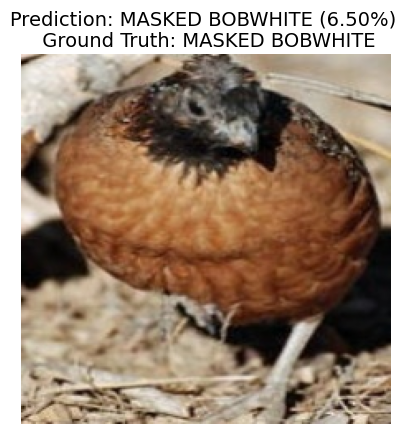

In [24]:
def predict(image_path: str, 
            class_names: List[str] = class_names,
            model: torch.nn.Module = trained_model,
            image_size: Tuple[int, int] = (config.INPUT_HEIGHT, config.INPUT_WIDTH),
            transform: torchvision.transforms = None,
            device: torch.device=config.DEVICE):

    if isinstance(image_path, pathlib.PosixPath):
        img = Image.open(image_path)
    else: 
        img = Image.open(requests.get(image_path, stream=True).raw)

    # create transformation for image (if one doesn't exist)
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=config.IMAGENET_MEAN,
                                 std=config.IMAGENET_STD),
        ])
    transformed_image = transform(img)

    # make sure the model is on the target device
    model.to(device)

    # turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = transformed_image.unsqueeze(dim=0)

        # make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # actual label
    ground_truth = PurePath(image_path).parent.name

    # predicted label
    prediction = class_names[target_image_pred_label]

    # predicted probability
    prediction_prob = target_image_pred_probs[0][target_image_pred_label].item()

    return prediction, prediction_prob, ground_truth
    
# predict on a single image
test_image_path_list = list(Path(config.TEST_DIR).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                        k=1) # sample 1 image path

# Make predictions on and plot the images
for i, image_path in enumerate(test_image_path_sample):
    prediction, prediction_prob, ground_truth = predict(image_path=image_path, 
                                                        class_names=class_names,
                                                        model=trained_model,
                                                        image_size=(config.INPUT_HEIGHT, config.INPUT_WIDTH),
                                                        transform=val_transforms,
                                                        device=config.DEVICE)
    # load the image
    image = Image.open(image_path)

    # plot the image
    plt.imshow(image)
    plt.title(f"Prediction: {prediction} ({prediction_prob*100:.2f}%) \n Ground Truth: {ground_truth}", fontsize=14)
    plt.axis('off')
    plt.savefig('./figures/single_image_prediction.png', format='png', dpi=600)




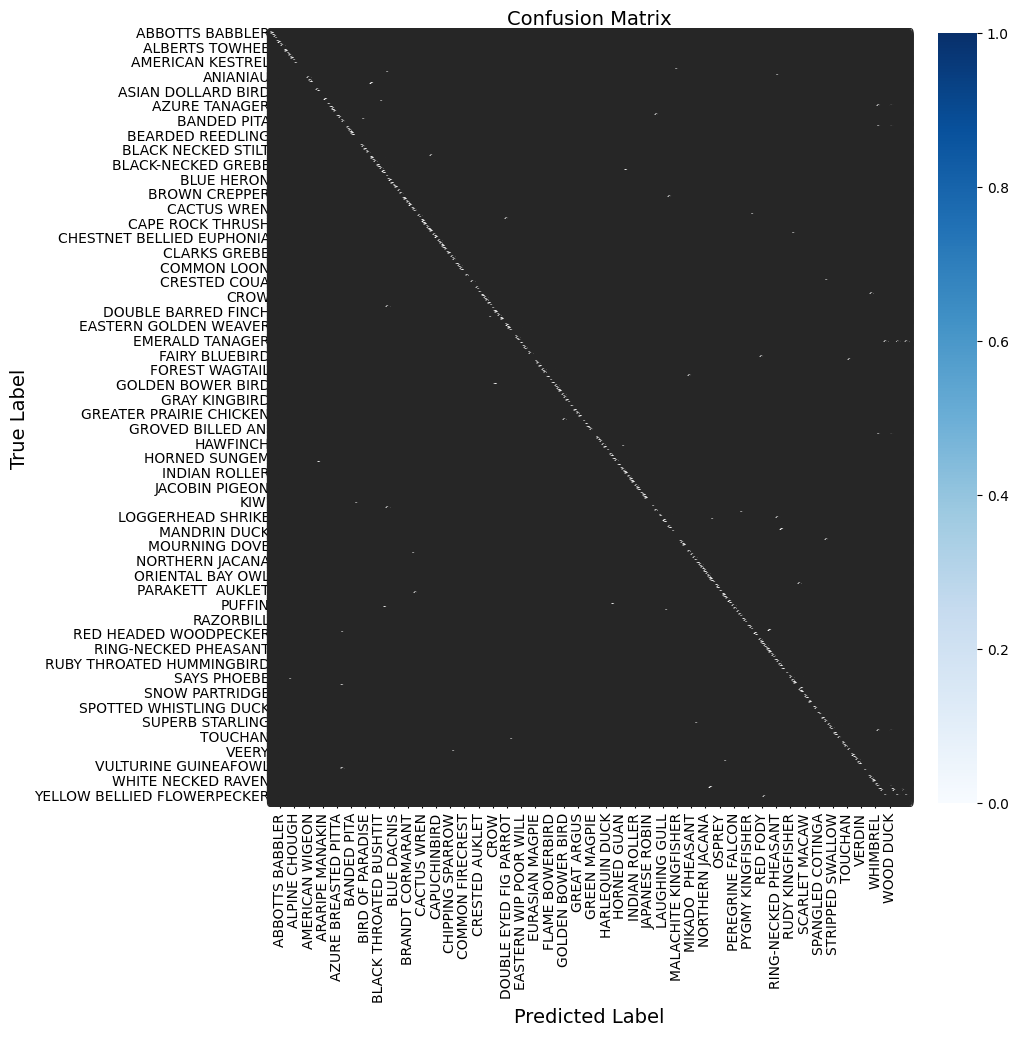

In [26]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plots a confusion matrix using seaborn's heatmap() function.
    """
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

    fig, ax = plt.subplots()
    sns.heatmap(cm_df, annot=True, cmap='Blues', ax=ax, fmt='.2f')
    ax.set_title('Confusion Matrix')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    plt.savefig('./figures/confusion_matrix.png', format='png')
    plt.show()

# predict on all images in test set
test_image_path_list = list(Path(config.TEST_DIR).glob("*/*.jpg")) # get list all image paths from test data 
# Make predictions on and plot the images
y_true = []
y_pred = []
for i, image_path in enumerate(test_image_path_list):
    prediction, prediction_prob, ground_truth = predict(image_path=image_path, 
                                                        class_names=class_names,
                                                        model=trained_model,
                                                        image_size=(config.INPUT_HEIGHT, config.INPUT_WIDTH),
                                                        transform=val_transforms,
                                                        device=config.DEVICE)
    y_true.append(ground_truth)
    y_pred.append(prediction)

plot_confusion_matrix(y_true, y_pred, class_names)


In [27]:
def pred_and_plot_image(image_path: str, 
                        subplot: Tuple[int, int, int],  # subplot tuple for `subplot()` function
                        class_names: List[str] = class_names,
                        model: torch.nn.Module = trained_model,
                        image_size: Tuple[int, int] = (config.INPUT_HEIGHT, config.INPUT_WIDTH),
                        transform: torchvision.transforms = None,
                        device: torch.device=config.DEVICE):

    if isinstance(image_path, pathlib.PosixPath):
        img = Image.open(image_path)
    else: 
        img = Image.open(requests.get(image_path, stream=True).raw)

    # create transformation for image (if one doesn't exist)
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=config.IMAGENET_MEAN,
                                 std=config.IMAGENET_STD),
        ])
    transformed_image = transform(img)

    # make sure the model is on the target device
    model.to(device)

    # turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = transformed_image.unsqueeze(dim=0)

        # make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # actual label
    ground_truth = PurePath(image_path).parent.name

    # plot image with predicted label and probability 
    plt.subplot(*subplot)
    plt.imshow(img)
    if isinstance(image_path, pathlib.PosixPath):
        title = f"Ground Truth: {ground_truth} | Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    else:
        title = f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    plt.title("\n".join(textwrap.wrap(title, width=25)),fontsize=10)  # wrap text using textwrap.wrap() function
    plt.axis(False)
    

def plot_random_test_images(model):
    num_images_to_plot = 9
    test_image_path_list = list(Path(config.TEST_DIR).glob("*/*.jpg")) # get list all image paths from test data 
    test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                           k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

    # set up subplots
    num_rows = int(np.ceil(num_images_to_plot / 3))
    fig, ax = plt.subplots(num_rows, 3, figsize=(10, num_rows * 3))
    ax = ax.flatten()

    # Make predictions on and plot the images
    for i, image_path in enumerate(test_image_path_sample):
        pred_and_plot_image(model=model, 
                            image_path=image_path,
                            class_names=class_names,
                            subplot=(num_rows, 3, i+1),  # subplot tuple for `subplot()` function
                            image_size=(config.INPUT_HEIGHT, config.INPUT_WIDTH))

    # adjust spacing between subplots
    plt.subplots_adjust(wspace=1)
    plt.show()
    # save the predictions plot
    plt.savefig('./figures/predictions.png', format='png', dpi=300)

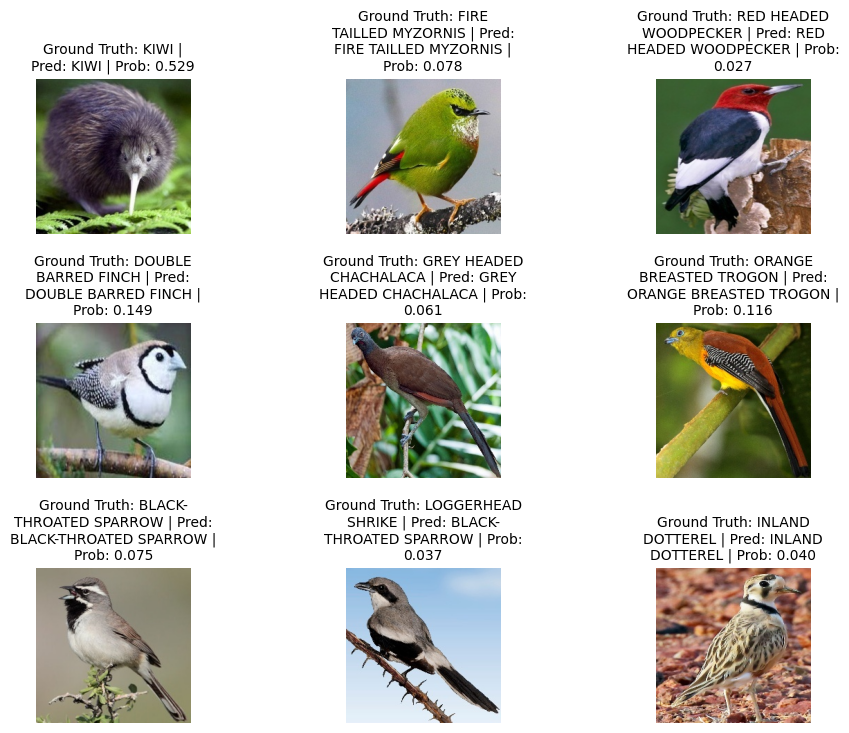

<Figure size 640x480 with 0 Axes>

In [28]:
plot_random_test_images(trained_model)

# Predict on images from internet

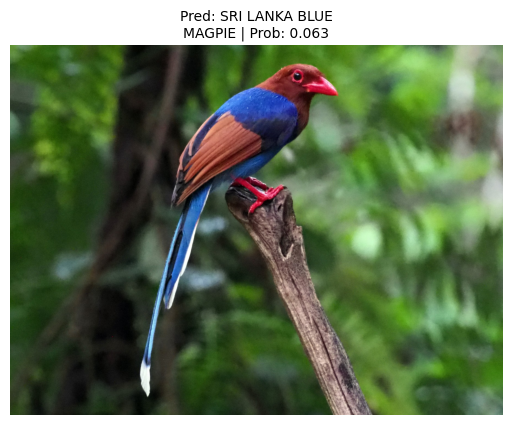

In [29]:
#Sri Lankan blue magpie
image_url = 'https://cdn.download.ams.birds.cornell.edu/api/v1/asset/252002651/1800'
pred_and_plot_image(image_path= image_url, subplot=(1, 1, 1))